In [32]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from dtaidistance import dtw
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
def fast_dtw_distance(ref, compare_arr):
    distances = np.empty(compare_arr.shape[0])
    for i in range(compare_arr.shape[0]):
        distances[i] = dtw.distance(ref, compare_arr[i])
    distances[distances == 0] = 1
    return distances

def create_time_index(timeend: np.datetime64, window_size: int) -> pd.DatetimeIndex:
    freq = '10min'
    return pd.date_range(end=timeend, periods=window_size, freq=freq)

def safe_nansum(arr, axis=None):
    result = np.nansum(arr, axis=axis)
    # 判斷原始陣列沿 axis 全部是 NaN 的位置
    all_nan = np.isnan(arr).all(axis=axis)
    
    # 將那些位置改為 np.nan
    if np.isscalar(result):
        return np.nan if all_nan else result
    result = result.astype('float64')  # 確保能裝 NaN
    result[all_nan] = np.nan
    return result

In [34]:
a_tdf = pd.DataFrame()
for i in range(0,40):
    try:
        df = pd.read_csv(f'../data/Raw_Data/Gogoro/台北市大安區_臺大二活停車場站A ({i:02d}).csv',index_col=0)
        df.index = pd.to_datetime(df.index)
        df.index = df.index.floor('min')
        df = df[~df.index.duplicated()]
        a_tdf = pd.concat([a_tdf,df])
    except:
        continue
a_tdf = a_tdf[~a_tdf.index.duplicated()]
a_tdf.sort_index(inplace=True)

b_tdf = pd.DataFrame()
for i in range(0,37):
    try:
        df = pd.read_csv(f'../data/Raw_Data/Gogoro/台北市大安區_臺大二活停車場站B ({i:02d}).csv',index_col=0)
        df.index = pd.to_datetime(df.index)
        df.index = df.index.floor('min')
        df = df[~df.index.duplicated()]
        b_tdf = pd.concat([b_tdf,df])
    except:
        continue
b_tdf = b_tdf[~b_tdf.index.duplicated()]
b_tdf.sort_index(inplace=True)

tdf = pd.concat([a_tdf,b_tdf],axis=1).dropna().sum(axis=1)

In [35]:
# 計算時間差（Timedelta 型別）
time_deltas = tdf.index.to_series().diff().dropna()

# 轉為秒數（float 型別）
time_deltas_seconds = time_deltas.dt.total_seconds()/60

# 基本統計量
stats = time_deltas_seconds.describe()

print("時間間隔（分）統計特徵：")
print(stats)

時間間隔（分）統計特徵：
count      5758.000000
mean        155.786037
std        6590.929095
min           1.000000
25%          10.000000
50%          19.000000
75%          35.000000
max      479748.000000
Name: time, dtype: float64


In [36]:
# 假設 df 已經處理好 index 是 datetime 且只保留到分鐘
start = tdf.index.min()
end = tdf.index.max()

# 產生每分鐘的完整時間序列
full_index = pd.date_range(start=start, end=end, freq='1min')

# 將原始 df 補上缺的時間，空值保持為 NaN
tdf_filled = tdf.reindex(full_index)

tdf_filled = tdf_filled.resample('10min').mean()
tdf_filled.name = 'raw_data'

In [37]:
# 轉為 xarray DataArray
da = xr.DataArray(tdf_filled, dims='time')

# 定義滑動視窗參數
window_size = 12 * 6    # 72 個點（12 小時 * 每10分鐘）
step_size = 1         # 每 1 小時（6 個點）滑動一次

# 建立滑動視窗
rolling_windows = da.rolling(time=window_size, center=False).construct('window')

# 下採樣：每 step_size 個點保留一個視窗
sampled_windows = rolling_windows.isel(time=slice(0, None, step_size))

# 將結果轉為 numpy 陣列 (samples, time steps)
samples = sampled_windows.transpose('time', 'window').values

# 篩選掉含 nan 的視窗
valid_mask = np.isnan(samples).sum(axis=1) < window_size-2
samples = samples[valid_mask]
index = sampled_windows.transpose('time', 'window')['time'].values[valid_mask]

In [38]:
for i in range(samples.shape[0]):
    ref_con = ~np.isnan(samples[i])
    target_con = ~np.any(np.isnan(samples[:,ref_con]),axis=1)
    print(samples[target_con,:][:,ref_con].shape)

(881, 3)
(881, 3)
(437, 4)
(231, 5)
(231, 5)
(133, 6)
(87, 7)
(87, 7)
(61, 8)
(61, 8)
(61, 8)
(43, 9)
(43, 9)
(39, 10)
(39, 10)
(32, 11)
(28, 12)
(28, 12)
(24, 13)
(24, 13)
(22, 14)
(19, 15)
(19, 15)
(16, 16)
(15, 17)
(13, 18)
(13, 18)
(13, 18)
(10, 19)
(10, 20)
(10, 20)
(7, 21)
(7, 21)
(6, 22)
(6, 23)
(6, 23)
(6, 23)
(6, 23)
(5, 24)
(5, 24)
(5, 24)
(4, 25)
(4, 25)
(4, 25)
(4, 25)
(4, 25)
(4, 26)
(4, 26)
(4, 26)
(4, 27)
(4, 27)
(4, 27)
(4, 27)
(2, 28)
(2, 28)
(2, 28)
(2, 29)
(2, 29)
(2, 30)
(2, 31)
(2, 31)
(2, 32)
(2, 33)
(2, 33)
(2, 33)
(1, 34)
(1, 33)
(1, 33)
(1, 34)
(1, 33)
(1, 33)
(1, 33)
(1, 32)
(1, 33)
(1, 32)
(1, 32)
(1, 33)
(1, 32)
(1, 32)
(1, 33)
(1, 33)
(1, 33)
(1, 34)
(1, 33)
(1, 34)
(1, 33)
(1, 33)
(1, 33)
(1, 32)
(1, 32)
(1, 32)
(1, 33)
(1, 33)
(1, 32)
(1, 32)
(1, 32)
(1, 31)
(1, 30)
(1, 30)
(1, 31)
(1, 31)
(2, 31)
(2, 31)
(2, 31)
(2, 32)
(2, 31)
(2, 31)
(2, 31)
(2, 32)
(2, 32)
(2, 31)
(2, 32)
(2, 32)
(2, 32)
(2, 32)
(2, 33)
(2, 33)
(2, 34)
(2, 34)
(2, 34)
(2, 35)
(2, 34)


In [73]:

# 要查找的目標時間
target_time = np.datetime64('2024-02-07 08:50:00')

# 計算與目標時間的絕對時間差距，取最小值的位置
nearest_index = np.argmin(np.abs(index - target_time))
nearest_index

np.int64(5650)

In [86]:
i=5650
ref_con = ~np.isnan(samples[i])
target_con = ~np.any(np.isnan(samples[:,ref_con]),axis=1)
distance = fast_dtw_distance(samples[i][ref_con], samples[target_con,:][:,ref_con])  # shape = (881,)

In [87]:
samples[i][ref_con]

array([20., 22., 12., 12., 12., 22., 22., 34., 34., 38., 40., 40., 16.])

In [89]:
samples[target_con,:][:,ref_con][10]

array([31., 33., 28., 26., 29., 35., 35., 43., 43., 45., 45., 49., 39.])

In [88]:
(1/distance[1:]**2)/(1/distance[1:]**2).sum()

array([0.0767058 , 0.08018276, 0.04455284, 0.03295098, 0.02935734,
       0.03724863, 0.0410308 , 0.04270882, 0.04290968, 0.10760715,
       0.11105389, 0.09832962, 0.06055016, 0.04290968, 0.03553815,
       0.03046128, 0.03041318, 0.02639792, 0.02909131])

In [ ]:
p = 2
series_list = []
ref_con = ~np.isnan(samples[i])
target_con = ~np.any(np.isnan(samples[:,ref_con]),axis=1)
distance = fast_dtw_distance(samples[i][ref_con], samples[target_con,:][:,ref_con])  # shape = (881,)
if distance.shape[0] == 1:
    continue
inverse_distance = 1/distance
inverse_distance[0] = 0
weight = inverse_distance**p
valid_mask = ~np.isnan(samples[target_con,:])
weighted_mask = weight[:,None]*valid_mask
col_weight_sum = np.sum(weighted_mask, axis=0, keepdims=True)
col_weight_sum[col_weight_sum==0]=1
norm_weight  = weighted_mask/col_weight_sum
result = np.nansum(samples[target_con,:]*norm_weight,axis=0)
timeend = index[i]
time_index = create_time_index(timeend, window_size)
series = pd.Series(result, index=time_index, name=samples[target_con,:][:,ref_con].shape[1])
series_list.append(series)
analogy_result = pd.concat(series_list, axis=1)

In [39]:
p = 2
series_list = []
for i in range(samples.shape[0]):
    ref_con = ~np.isnan(samples[i])
    target_con = ~np.any(np.isnan(samples[:,ref_con]),axis=1)
    distance = fast_dtw_distance(samples[i][ref_con], samples[target_con,:][:,ref_con])  # shape = (881,)
    if distance.shape[0] == 1:
        continue
    inverse_distance = 1/distance
    inverse_distance[0] = 0
    weight = inverse_distance**p
    valid_mask = ~np.isnan(samples[target_con,:])
    weighted_mask = weight[:,None]*valid_mask
    col_weight_sum = np.sum(weighted_mask, axis=0, keepdims=True)
    col_weight_sum[col_weight_sum==0]=1
    norm_weight  = weighted_mask/col_weight_sum
    result = np.nansum(samples[target_con,:]*norm_weight,axis=0)
    timeend = index[i]
    time_index = create_time_index(timeend, window_size)
    series = pd.Series(result, index=time_index, name=samples[target_con,:][:,ref_con].shape[1])
    series_list.append(series)
analogy_result = pd.concat(series_list, axis=1)

In [40]:
# 假設 df 已經處理好 index 是 datetime 且只保留到分鐘
start = analogy_result.index.min()
end = analogy_result.index.max()

# 產生每分鐘的完整時間序列
full_index = pd.date_range(start=start, end=end, freq='10min')

# 將原始 df 補上缺的時間，空值保持為 NaN
analogy_result_filled = analogy_result.reindex(full_index)

In [59]:
valid_mask = ~np.isnan(analogy_result_filled.values)
weight = (pd.DataFrame(np.tile(analogy_result_filled.columns.to_numpy(), (analogy_result_filled.shape[0], 1)))).values
weight = np.log(weight)
weighted_mask = weight*valid_mask
col_weight_sum = np.sum(weighted_mask, axis=1, keepdims=True)
col_weight_sum[col_weight_sum==0]=1
norm_weight  = weighted_mask/col_weight_sum
result = safe_nansum(analogy_result_filled.values*norm_weight,axis=1)
result = pd.Series(result, index=analogy_result_filled.index,name='analogy_result').dropna()

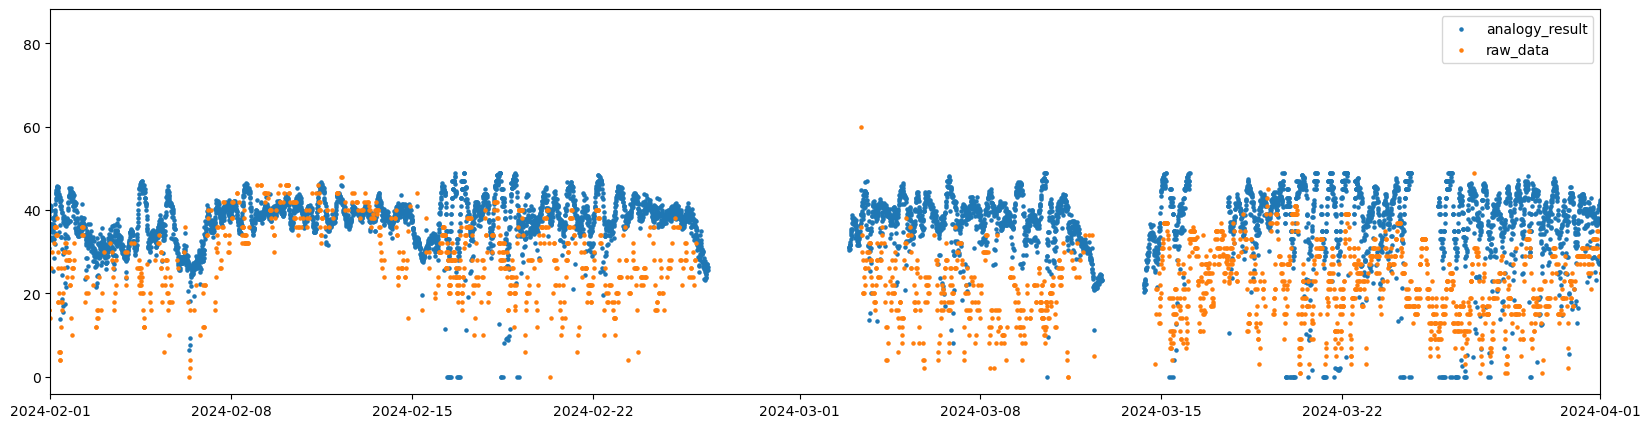

In [60]:
plt.figure(figsize=(20,5))
plt.scatter(result.index,result.values,label='analogy_result',s=5)
plt.scatter(tdf_filled.index,tdf_filled.values,label='raw_data',s=5)
plt.xlim(np.datetime64('2024-02-01'),np.datetime64('2024-04-01'))
plt.legend()
plt.show()

In [61]:
concat_df = pd.concat([result,tdf_filled],axis=1)

In [62]:
concat_df.iloc[58000:58050,:]

,analogy_result,raw_data
2024-02-07 08:10:00,36.966059,NaN
2024-02-07 08:20:00,36.792983,NaN
2024-02-07 08:30:00,37.097325,NaN
2024-02-07 08:40:00,36.434774,NaN
2024-02-07 08:50:00,36.935589,16.0
2024-02-07 09:00:00,38.243379,NaN
2024-02-07 09:10:00,37.833506,18.0
2024-02-07 09:20:00,40.358661,NaN
2024-02-07 09:30:00,39.307165,24.0
2024-02-07 09:40:00,39.893099,NaN
